In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from lib import calculate_normalize as CalNorm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 50
BATCH_SIZE = 64

In [3]:
# cuda 확인
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [ ]:
trainset = datasets.CIFAR100('./.data',
                             train=True,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))
testset = datasets.CIFAR100('./.data',
                             train=False,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))
mean_, std_ = CalNorm(trainset)
print("mean = {}\nstd = {}".format(mean_, std_))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset = datasets.CIFAR100('./.data',
                             train=True,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean_, std_)
                             ]))
testset = datasets.CIFAR100('./.data',
                             train=False,
                             download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean_, std_)
                             ]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3136, 625)
        self.fc2 = nn.Linear(625, 100)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, traget) in enumerate(train_loader):
        data, target = data.to(DEVICE), traget.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
loss = []
accuracy = []

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss.append(test_loss)
    accuracy.append(test_accuracy)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.134675
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.371560
[1] Test Loss: 2.2735, Accuracy: 43.57%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.089388
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.311030
[2] Test Loss: 2.2744, Accuracy: 43.20%
Train Epoch: 3 [0/50000 (0%)]	Loss: 2.402704
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.139050
[3] Test Loss: 2.2625, Accuracy: 43.51%
Train Epoch: 4 [0/50000 (0%)]	Loss: 2.144802
Train Epoch: 4 [32000/50000 (64%)]	Loss: 2.170556
[4] Test Loss: 2.2628, Accuracy: 43.50%
Train Epoch: 5 [0/50000 (0%)]	Loss: 2.238356
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.744372
[5] Test Loss: 2.2750, Accuracy: 43.30%
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.900973
Train Epoch: 6 [32000/50000 (64%)]	Loss: 2.411758
[6] Test Loss: 2.2594, Accuracy: 43.59%
Train Epoch: 7 [0/50000 (0%)]	Loss: 1.694844
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.862005
[7] Test Loss: 2.2463, Accuracy: 43.77%
Train Epoch: 8 [0/50000 (0%)]	Loss: 1.885464
Train Epoc

In [ ]:
PATH = './.models/CNN_Model.pt'

In [ ]:
# saving model
torch.save(model.state_dict(), PATH)

In [ ]:
loss = np.array(loss)
accuracy = np.array(accuracy)
epochs = np.array([x for x in range(1, EPOCHS + 1)])

In [ ]:
df = pd.DataFrame({'epoch': epochs,
                   'loss': loss,
                   'accuracy': accuracy})
df.to_csv(".result/CNN_result.csv", index=False)

Text(0, 0.5, 'Accuracy')

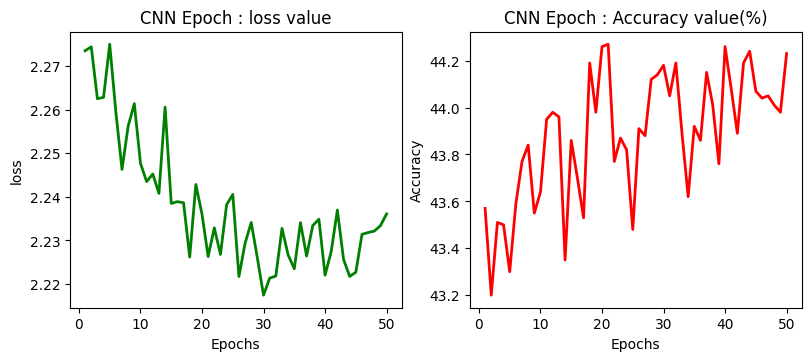

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3.5), layout="constrained")

axs[0].plot(epochs, loss, c='g', linewidth=2)
axs[0].set_title('CNN Epoch : loss value')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('loss')

axs[1].plot(epochs, accuracy, c='r', linewidth=2)
axs[1].set_title('CNN Epoch : Accuracy value(%)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')